# Overview

This notebook describes the different stages to build up different machine learning models trained over the dataset called **Fakeddit** by using  both **Word2Vec** and **Glove** Embeddings, for the automatic fake news detection

List of Machine Learning algorithms included 
- SVM
- Random Forest
- XgBoost
- KNN
- Naive Bayes
- Logistic Regression



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk 
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading the Full prepared dataset - Fakeddit cleaned data using nltk library on earlier works

In [2]:
final_df=pd.read_csv("Updated//fakeddit_full_valid_cleaned_comment_using_nltk.csv")

***
## 2. Dataset Cleaning and Preprocessing

#### Remove null values in the fulltext column

In [3]:
final_df=final_df.dropna()

##### Checking NUll values

In [5]:
final_df.isnull().sum()

id                0
domain            0
num_comments      0
subreddit         0
clean_title       0
class             0
submission_id     0
comments          0
clean_comments    0
fulltext          0
dtype: int64

##### Shuffling the rows

In [6]:
final_df = final_df.sample(frac = 1)

#### Create a copy of the dataframe

In [8]:
import copy
df=copy.deepcopy(final_df)

Create a new dataframe with two columns **fulltext and class**

In [9]:
df=df[['fulltext','class']]

#### Preprocess the fulltext column using the built in cleaner option in gensim library

In [11]:
# Clean data using the built in cleaner in gensim
df['cleantext'] = df['fulltext'].apply(lambda x: gensim.utils.simple_preprocess(x))
df.head(1)

,fulltext,class,cleantext
316077,after years of tyranny opposition has won in the capital ankara and istanbul in turkey change change good,1,"[after, years, of, tyranny, opposition, has, won, in, the, capital, ankara, and, istanbul, in, turkey, change, change, good]"


***

## 3. Model Training and Evaluation

### Splitting dataset into train and test

In [12]:
train, test = train_test_split(df[['cleantext','class']], test_size=0.3,stratify=df['class'], random_state=0)

##### Shuffling the rows and  filtering data around 50% 

In [17]:
train_filtered = train.sample(frac=.5)
test_filtered = test.sample(frac=.5)

### Splitting dataset into train and test

In [22]:
X_train=train_filtered['cleantext']
y_train=train_filtered['class']

X_test=test_filtered['cleantext']
y_test=test_filtered['class']

### Feature Extractions using pretrained word2vec model

#### Load Gensim Downloader library

In [25]:
import gensim.downloader

##### Download or Load the  pretrained model

In [27]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#### After downloading it, you can load it as follows

In [32]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [33]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 17.9 s, sys: 1.41 s, total: 19.3 s
Wall time: 19.3 s
done loading Word2Vec


#### Then inspect the model by getting the list of index of key values from the pretrained model

In [34]:
#Inspect the model
word2vec_vocab = list(w2v_model.index_to_key)

In [35]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### User defined Function to create a feature vector by averaging all embeddings for the given sentence using the below user defined function

In [36]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats


167864


#### Then fit the training data and transform both training and test data

In [37]:
train_vectors = embedding_feats(X_train)
test_vectors = embedding_feats(X_test)

71942


####  User defined helper functions to find out the accuracy score metrics and creation of model comparison table


- The function named **metrics** is using to calculate the score of the different metrics such as Accuracy, Precision, Recall, F1Score and ROC AUC score for the given classifier with test data


- The function named **model_comparison_table** is using to create dataframe to list down all the classifiers with the metrics scores for the comparison purpose

In [38]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [39]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

***
## Model Training 

### XgBoost

**Initialise the  model and  fit using train data and save it to a path**

In [32]:
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_xgboost_word2vec.sav'
pickle.dump(xg_clf, open(filename, 'wb'))
print('XGBoost - Completed')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

**Load the trained model to make predictions on the test data and measure the accuracy metrics**

In [48]:
#Loading the model
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_xgboost_word2vec.sav'

xg_clf_loaded = pickle.load(open(filename, 'rb'))
result = xg_clf_loaded.score(test_vectors, y_test)
print(result)


pred = xg_clf_loaded.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8598871313002141
Accuracy score : 0.8598871313002141
Confusion matrix : 
 [[15590  6574]
 [ 3506 46272]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.70      0.76     22164
           1       0.88      0.93      0.90     49778

    accuracy                           0.86     71942
   macro avg       0.85      0.82      0.83     71942
weighted avg       0.86      0.86      0.86     71942

Precision : 0.8756008023313022
Recall : 0.9295672787175058
F1 Score : 0.9017773620205799


**Plot confusion matrix using the user defined functions as mentioned above earlier**

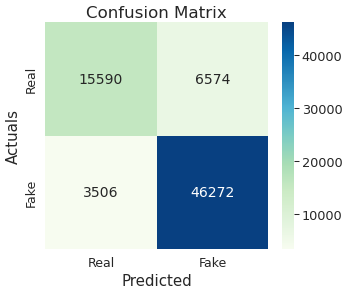

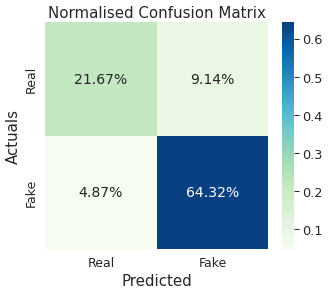

In [49]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_word2vec//fakeddit_ml_XG_word2vec_cmtrx.png"
path2="outputs//fakeddit_ml_word2vec//fakeddit_ml_XG_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### RandomForest


**Initialise the  model and  fit using train data and save it to a path**

In [24]:
rf = RandomForestClassifier(random_state=0)
rf_model = rf.fit(train_vectors, y_train.values.ravel())

# save the model to disk
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_RF_word2vec.sav'
pickle.dump(rf_model, open(filename, 'wb'))
print('RandomForest - Completed')


**Load the saved model and predict using test data and measure the accuracy metrics**

In [50]:
#Loading the model
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_RF_word2vec.sav'

rf_model_loaded = pickle.load(open(filename, 'rb'))
result = rf_model_loaded.score(test_vectors, y_test)
print(result)


pred = rf_model_loaded.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


0.9610936587806844
Accuracy score : 0.9610936587806844
Confusion matrix : 
 [[19916  2248]
 [  551 49227]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     22164
           1       0.96      0.99      0.97     49778

    accuracy                           0.96     71942
   macro avg       0.96      0.94      0.95     71942
weighted avg       0.96      0.96      0.96     71942

Precision : 0.9563283147158815
Recall : 0.9889308529872635
F1 Score : 0.972356374625937


**Plot confusion matrix using the user defined functions as mentioned above earlier**

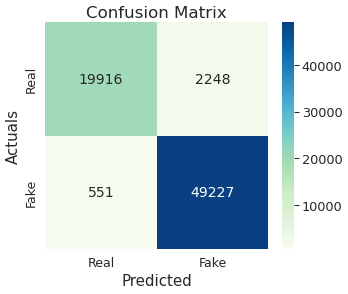

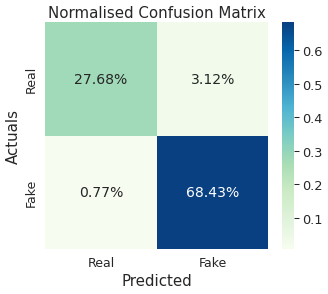

In [51]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_word2vec//fakeddit_ml_RF_word2vec_cmtrx.png"
path2="outputs//fakeddit_ml_word2vec//fakeddit_ml_RF_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## SVM


**Initialise the  model and  fit using train data and save it to a path**

In [ ]:
svm_clf=SVC(random_state=0,probability=True)
svm_clf.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_SVM_word2vec.sav'
pickle.dump(svm_clf, open(filename, 'wb'))
print('SVM - Completed')

**Load the saved model and predict using test data and measure the accuracy metrics**

In [40]:
#Loading the model
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_SVM_word2vec.sav'

svm_model_loaded = pickle.load(open(filename, 'rb'))
result = svm_model_loaded.score(test_vectors, y_test)
print(result)


pred = svm_model_loaded.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


0.8638208556893052
Accuracy score : 0.8638208556893052
Confusion matrix : 
 [[15748  6416]
 [ 3381 46397]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     22164
           1       0.88      0.93      0.90     49778

    accuracy                           0.86     71942
   macro avg       0.85      0.82      0.83     71942
weighted avg       0.86      0.86      0.86     71942

Precision : 0.8785147596235775
Recall : 0.9320784282213026
F1 Score : 0.9045042937489643


**Plot confusion matrix using the user defined functions as mentioned above earlier**

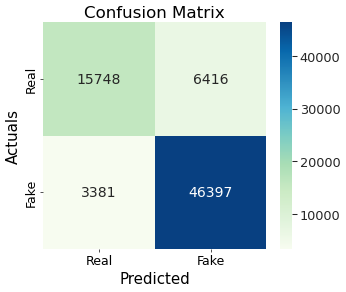

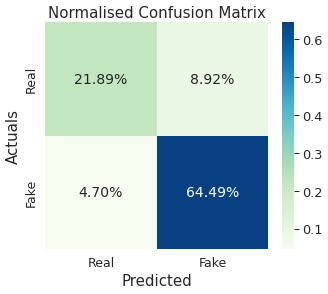

In [41]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_word2vec//fakeddit_ml_SVM_word2vec_cmtrx.png"
path2="outputs//fakeddit_ml_word2vec//fakeddit_ml_SVM_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### KNN


**Initialise the  model and  fit using train data and save it to a path**

In [ ]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_vectors,y_train)
# save the model to disk
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_KNN_word2vec.sav'
pickle.dump(knn_clf, open(filename, 'wb'))
print('KNN - Completed')

**Load the saved model and predict using test data and measure the accuracy metrics**

In [42]:
#Loading the model
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_KNN_word2vec.sav'

knn_model_loaded = pickle.load(open(filename, 'rb'))
result = knn_model_loaded.score(test_vectors, y_test)
print(result)


pred = knn_model_loaded.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


0.8165605626754886
Accuracy score : 0.8165605626754886
Confusion matrix : 
 [[15633  6531]
 [ 6666 43112]]
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.71      0.70     22164
           1       0.87      0.87      0.87     49778

    accuracy                           0.82     71942
   macro avg       0.78      0.79      0.79     71942
weighted avg       0.82      0.82      0.82     71942

Precision : 0.8684406663577946
Recall : 0.8660854192615212
F1 Score : 0.8672614437593666


**Plot confusion matrix using the user defined functions as mentioned above earlier**

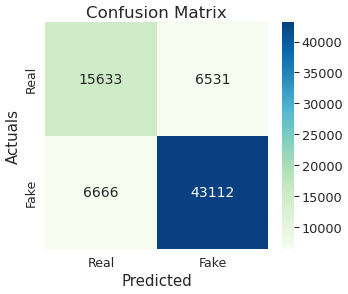

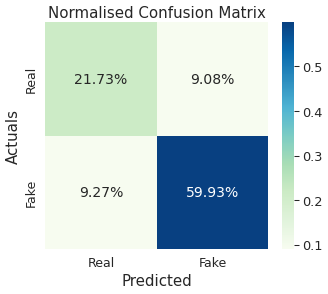

In [43]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_word2vec//fakeddit_ml_KNN_word2vec_cmtrx.png"
path2="outputs//fakeddit_ml_word2vec//fakeddit_ml_KNN_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naive Bayes


**Initialise the  model and  fit using train data and save it to a path**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf=GaussianNB()
nb_clf.fit(train_vectors,y_train) 
# save the model to disk
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_NB_word2vec.sav'
pickle.dump(nb_clf, open(filename, 'wb'))
print('Naive Bayes - Completed')

**Load the saved model and predict using test data and measure the accuracy metrics**

In [44]:
#Loading the model
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_NB_word2vec.sav'

nb_model_loaded = pickle.load(open(filename, 'rb'))
result = nb_model_loaded.score(test_vectors, y_test)
print(result)


pred = nb_model_loaded.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


0.5524172249867949
Accuracy score : 0.5524172249867949
Confusion matrix : 
 [[16929  5235]
 [26965 22813]]
Classification Report
              precision    recall  f1-score   support

           0       0.39      0.76      0.51     22164
           1       0.81      0.46      0.59     49778

    accuracy                           0.55     71942
   macro avg       0.60      0.61      0.55     71942
weighted avg       0.68      0.55      0.56     71942

Precision : 0.8133556759840274
Recall : 0.45829482904094176
F1 Score : 0.5862565209570066


**Plot confusion matrix using the user defined functions as mentioned above earlier**

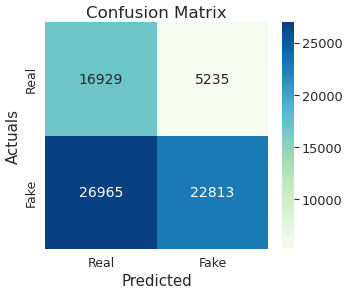

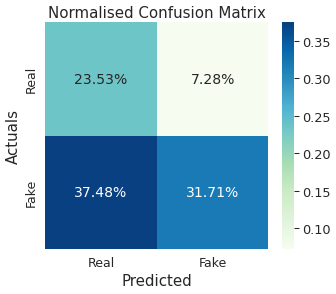

In [45]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_word2vec//fakeddit_ml_NB_word2vec_cmtrx.png"
path2="outputs//fakeddit_ml_word2vec//fakeddit_ml_NB_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression


**Initialise the  model and  fit using train data and save it to a path**

In [ ]:
from sklearn.linear_model import LogisticRegression

logticreg_clf=LogisticRegression()

logticreg_clf.fit(train_vectors,y_train)
# save the model to disk
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_Logistic_word2vec.sav'
pickle.dump(logticreg_clf, open(filename, 'wb'))
print('Logistic Regression - Completed')

**Load the saved model and predict using test data and measure the accuracy metrics**

In [46]:
#Loading the model
filename = 'outputs//fakeddit_ml_word2vec//fakeddit_Logistic_word2vec.sav'

lr_model_loaded = pickle.load(open(filename, 'rb'))
result = lr_model_loaded.score(test_vectors, y_test)
print(result)


pred = lr_model_loaded.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


0.787801284367963
Accuracy score : 0.787801284367963
Confusion matrix : 
 [[11869 10295]
 [ 4971 44807]]
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.54      0.61     22164
           1       0.81      0.90      0.85     49778

    accuracy                           0.79     71942
   macro avg       0.76      0.72      0.73     71942
weighted avg       0.78      0.79      0.78     71942

Precision : 0.8131646764182788
Recall : 0.9001366065330065
F1 Score : 0.854443173150267


**Plot confusion matrix using the user defined functions as mentioned above earlier**

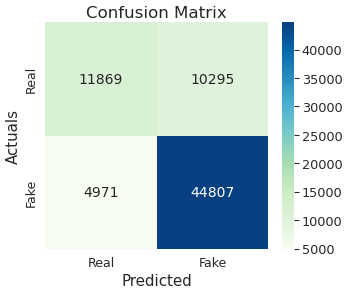

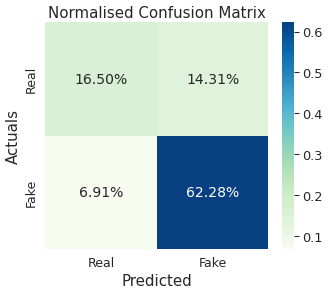

In [47]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_word2vec//fakeddit_ml_LR_word2vec_cmtrx.png"
path2="outputs//fakeddit_ml_word2vec//fakeddit_ml_LR_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot using all the algorithms

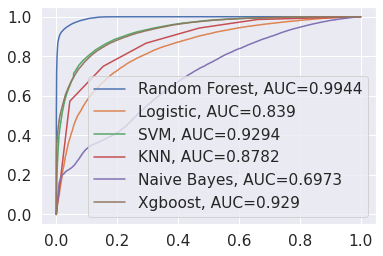

In [54]:
#set up plotting area
plt.figure(0).clf()

#fit RF model and plot ROC curve
y_pred = rf_model_loaded.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve
y_pred = lr_model_loaded.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve
y_pred = svm_model_loaded.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve
y_pred = knn_model_loaded.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve
y_pred = nb_model_loaded.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve
y_pred = xg_clf_loaded.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()

## Feature Extraction using Pretrained Glove

##### Download the pretrained zip file

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

#### Load the downloaded the 300 dimension Glove pretrained model "glove.6B.300d.txt" in a path and convert to word2vec format",

In [55]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [56]:
path_to_model = '//gpfs//home//psc21zcu//FakeNews_Detection/Dissertation_Work//Embeddings//glove.6B.300d.txt'
output_file = '//gpfs//home//psc21zcu//FakeNews_Detection/Dissertation_Work//Embeddings///gensim_glove.6B.300d.txt'
glove2word2vec(path_to_model, output_file)

(400000, 300)

#### Then load the converted glove model 

In [58]:
%time glove_model = KeyedVectors.load_word2vec_format(output_file, binary=False)
print('done loading Glove Pretrained Embedding')

CPU times: user 39.5 s, sys: 426 ms, total: 39.9 s
Wall time: 40 s
done loading Glove Pretrained Embedding


### Function to create a feature vector by averaging all embeddings for the given sentence 

In [59]:
def glove_embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in glove_model:
                feat_for_this += glove_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats



167864


#### Then fit the training data and transform both training and test data

In [60]:
glove_train_vectors = glove_embedding_feats(X_train)
glove_test_vectors = glove_embedding_feats(X_test)
print(len(glove_test_vectors))

71942


*** 
### RandomForest


**Initialise the  model and  fit using train data and save it to a path**

In [53]:
rf = RandomForestClassifier(random_state=0)
rf_clf_g = rf.fit(glove_train_vectors, y_train.values.ravel())

# save the model to disk
filename = 'outputs//fakeddit_ml_glove//fakeddit_RF_glove.sav'
pickle.dump(rf_clf_g, open(filename, 'wb'))
print('Random Forest - Completed')

**Load the saved model and predict using test data and measure the accuracy metrics**

In [61]:
#Loading the model
filename = 'outputs//fakeddit_ml_glove//fakeddit_RF_glove.sav'

rf_clf_g_loaded = pickle.load(open(filename, 'rb'))
result = rf_clf_g_loaded.score(glove_test_vectors, y_test)
print(result)


pred = rf_clf_g_loaded.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8697005921436712
Accuracy score : 0.8697005921436712
Confusion matrix : 
 [[14324  7840]
 [ 1534 48244]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.65      0.75     22164
           1       0.86      0.97      0.91     49778

    accuracy                           0.87     71942
   macro avg       0.88      0.81      0.83     71942
weighted avg       0.87      0.87      0.86     71942

Precision : 0.8602096854717923
Recall : 0.969183173289405
F1 Score : 0.9114507566454442


**Plot confusion matrix using the user defined functions as mentioned above earlier**

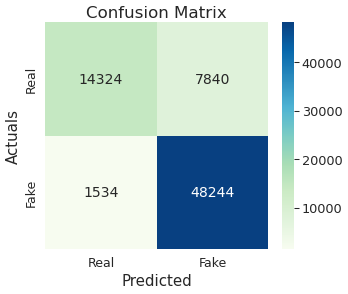

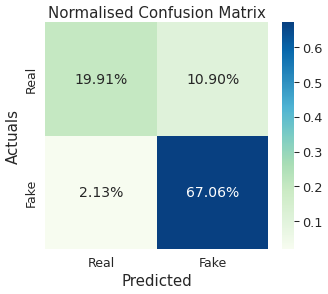

In [62]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_glove//fakeddit_ml_RF_glove_cmtrx.png"
path2="outputs//fakeddit_ml_glove//fakeddit_ml_RF_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Support Vector Machine


**Initialise the  model and  fit using train data and save it to a path**

In [55]:
svm_clf_g=SVC(random_state=0,probability=True)
svm_clf_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_glove//fakeddit_SVM_glove.sav'
pickle.dump(svm_clf_g, open(filename, 'wb'))
print('SVM - Completed')

**Load the saved model and predict using test data and measure the accuracy metrics**

In [63]:
#Loading the model
filename = 'outputs//fakeddit_ml_glove//fakeddit_SVM_glove.sav'

svm_clf_g_loaded = pickle.load(open(filename, 'rb'))
result = svm_clf_g_loaded.score(glove_test_vectors, y_test)
print(result)


pred = svm_clf_g_loaded.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8540212949320286
Accuracy score : 0.8540212949320286
Confusion matrix : 
 [[14935  7229]
 [ 3273 46505]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.67      0.74     22164
           1       0.87      0.93      0.90     49778

    accuracy                           0.85     71942
   macro avg       0.84      0.80      0.82     71942
weighted avg       0.85      0.85      0.85     71942

Precision : 0.8654669296906986
Recall : 0.9342480613925831
F1 Score : 0.8985431640775948


**Plot confusion matrix using the user defined functions as mentioned above earlier**

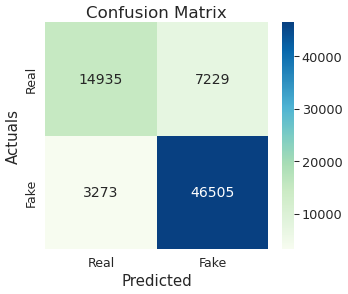

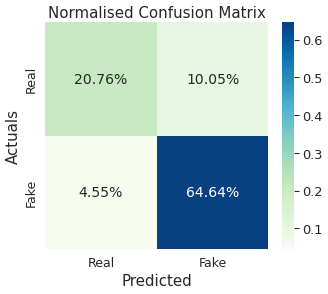

In [64]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_glove//fakeddit_ml_SVM_glove_cmtrx.png"
path2="outputs//fakeddit_ml_glove//fakeddit_ml_SVM_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## KNN


**Initialise the  model and  fit using train data and save it to a path**

In [58]:
#Create KNN Object.
knn_clf_g = KNeighborsClassifier()

knn_clf_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_glove//fakeddit_KNN_glove.sav'
pickle.dump(knn_clf_g, open(filename, 'wb'))
print('KNN - Completed')

**Load the saved model and predict using test data and measure the accuracy metrics**

In [65]:
#Loading the model
filename = 'outputs//fakeddit_ml_glove//fakeddit_KNN_glove.sav'

knn_clf_g_loaded = pickle.load(open(filename, 'rb'))
result = knn_clf_g_loaded.score(glove_test_vectors, y_test)
print(result)


pred = knn_clf_g_loaded.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8092491173445275
Accuracy score : 0.8092491173445275
Confusion matrix : 
 [[15688  6476]
 [ 7247 42531]]
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.71      0.70     22164
           1       0.87      0.85      0.86     49778

    accuracy                           0.81     71942
   macro avg       0.78      0.78      0.78     71942
weighted avg       0.81      0.81      0.81     71942

Precision : 0.8678556124635256
Recall : 0.8544135963678734
F1 Score : 0.8610821480994078


**Plot confusion matrix using the user defined functions as mentioned above earlier**

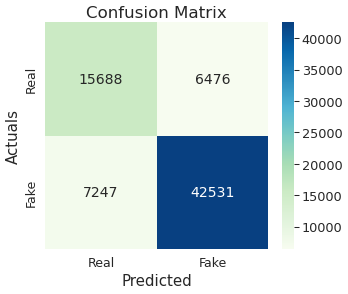

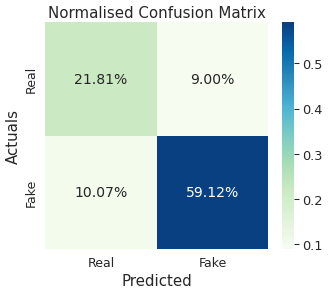

In [66]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_glove//fakeddit_ml_KNN_glove_cmtrx.png"
path2="outputs//fakeddit_ml_glove//fakeddit_ml_KNN_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## XgBoost


**Initialise the  model and  fit using train data and save it to a path**

In [76]:
xg_clf_g=XGBClassifier(random_state=0)

xg_clf_g.fit(glove_train_vectors,y_train)

import pickle

# save the model to disk
filename = 'outputs//fakeddit_ml_glove//fakeddit_xgboost_glove.sav'
pickle.dump(xg_clf_g, open(filename, 'wb'))
print('XgBoost - Completed')


XgBoost - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [78]:
#Loading the model
filename = 'outputs//fakeddit_ml_glove//fakeddit_xgboost_glove.sav'

xg_clf_g_loaded = pickle.load(open(filename, 'rb'))

pred = xg_clf_g_loaded.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.8225375997331184
Confusion matrix : 
 [[14045  8119]
 [ 4648 45130]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.63      0.69     22164
           1       0.85      0.91      0.88     49778

    accuracy                           0.82     71942
   macro avg       0.80      0.77      0.78     71942
weighted avg       0.82      0.82      0.82     71942

Precision : 0.8475276531014667
Recall : 0.9066254168508177
F1 Score : 0.8760810273035224


**Plot confusion matrix using the user defined functions as mentioned above earlier**

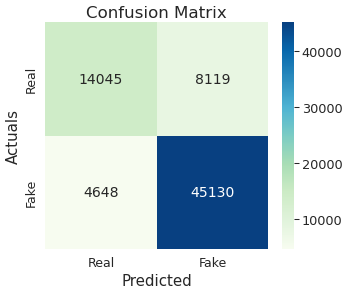

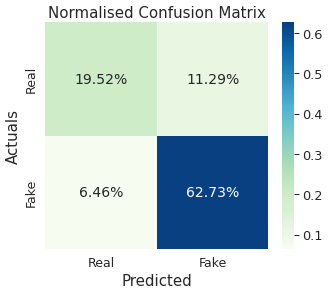

In [79]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_glove//fakeddit_ml_XG_glove_cmtrx.png"
path2="outputs//fakeddit_ml_glove//fakeddit_ml_XG_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naive Bayes


**Initialise the  model and  fit using train data and save it to a path**

In [114]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import BernoulliNB
nb_clf_g=GaussianNB()
#nb_clf_g=BernoulliNB(fit_prior = True,alpha=1.5)
nb_clf_g.fit(glove_train_vectors,y_train) 

# save the model to disk
filename = 'outputs//fakeddit_ml_glove//fakeddit_NB_glove.sav'
pickle.dump(nb_clf_g, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [116]:
#Loading the model
filename = 'outputs//fakeddit_ml_glove//fakeddit_NB_glove.sav'

nb_clf_g_loaded = pickle.load(open(filename, 'rb'))
# result = nb_clf_g_loaded.score(glove_test_vectors, y_test)
# print(result)

pred = nb_clf_g_loaded.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.5948402880097856
Confusion matrix : 
 [[14465  7699]
 [21449 28329]]
Classification Report
              precision    recall  f1-score   support

           0       0.40      0.65      0.50     22164
           1       0.79      0.57      0.66     49778

    accuracy                           0.59     71942
   macro avg       0.59      0.61      0.58     71942
weighted avg       0.67      0.59      0.61     71942

Precision : 0.7863050960364161
Recall : 0.5691068343444895
F1 Score : 0.6603034752814488


**Plot confusion matrix using the user defined functions as mentioned above earlier**

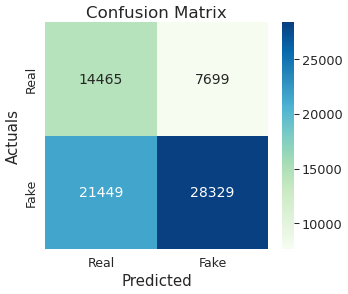

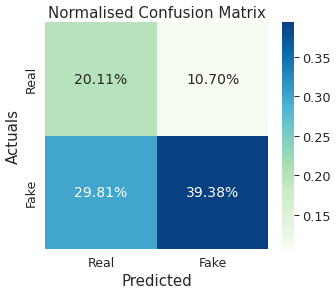

In [117]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_glove//fakeddit_ml_NB_glove_cmtrx.png"
path2="outputs//fakeddit_ml_glove//fakeddit_ml_NB_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression


**Initialise the  model and  fit using train data and save it to a path**

In [62]:
from sklearn.linear_model import LogisticRegression

In [159]:
logticreg_clf_g=LogisticRegression(C=100,solver='newton-cg',penalty='l2')

logticreg_clf_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_glove//fakeddit_Logistic_glove.sav'
pickle.dump(logticreg_clf_g, open(filename, 'wb'))
print('Logistic Regression - Completed')

Logistic Regression - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [160]:
#Loading the model
filename = 'outputs//fakeddit_ml_glove//fakeddit_Logistic_glove.sav'

logistic_clf_g_loaded = pickle.load(open(filename, 'rb'))
# result = nb_clf_g_loaded.score(glove_test_vectors, y_test)
# print(result)

pred = logistic_clf_g_loaded.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.7768619165438826
Confusion matrix : 
 [[11125 11039]
 [ 5014 44764]]
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.50      0.58     22164
           1       0.80      0.90      0.85     49778

    accuracy                           0.78     71942
   macro avg       0.75      0.70      0.71     71942
weighted avg       0.77      0.78      0.77     71942

Precision : 0.8021790943139258
Recall : 0.8992727711037004
F1 Score : 0.8479555980716228


**Plot confusion matrix using the user defined functions as mentioned above earlier**

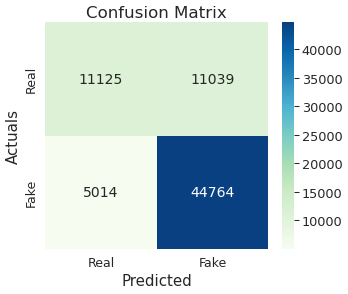

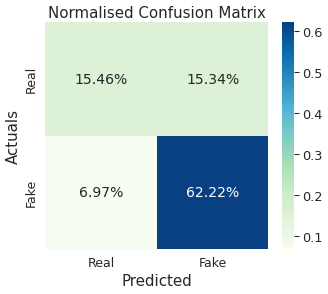

In [161]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_glove//fakeddit_ml_LR_glove_cmtrx.png"
path2="outputs//fakeddit_ml_glove//fakeddit_ml_LR_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot using all the algorithms

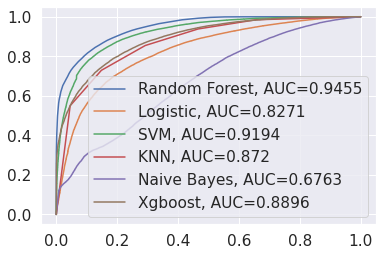

In [162]:
#set up plotting area
plt.figure(0).clf()

#fit RF model and plot ROC curve
y_pred = rf_clf_g_loaded.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve
y_pred = logistic_clf_g_loaded.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve
y_pred = svm_clf_g_loaded.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve
y_pred = knn_clf_g_loaded.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve
y_pred = nb_clf_g_loaded.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve
y_pred = xg_clf_g_loaded.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()